# Inference
This notebook is dedicated to testing and visualizing results for both the wiki and podcast datasets

Note: 
Apologies for the gratuitous warnings. Tensorflow is aware of these issues and has rectified them in later versions of TensorFlow. Unfortunately, they persist for version 1.13. 

In [1]:
from src.SliceNet import SliceNet
from src.netUtils import getSingleExample
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if type(tf.contrib) != type(tf): tf.contrib._warning = None
%load_ext autoreload
%autoreload 2

W0511 01:58:08.005508 140074867701504 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


importing hub
Instructions for updating:
Colocations handled automatically by placer.


W0511 01:58:10.119199 140074867701504 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [2]:
# Choose whether to use the base network or the network with self-attention
attention = True

# Current best networks
best_base_wiki = '/home/bmmidei/SliceCast/models/04_20_2019_2300_final.h5'
best_base_podcast = '/home/bmmidei/SliceCast/models/04_26_2019_1000_podcast.h5'
best_attn_wiki = '/home/bmmidei/SliceCast/models/05_03_2019_0800_attn.h5'
best_attn_podcast = '/home/bmmidei/SliceCast/models/05_02_2019_2200_attn_podcast.h5'

if attention:
    weights_wiki = best_attn_wiki
    weights_podcast = best_attn_podcast
else:
    weights_wiki = best_base_wiki
    weights_podcast = best_base_podcast

net = SliceNet(classification=True,
               class_weights=[1.0,10,0.2],
               attention=attention)

## Sample predictions on unseen wiki articles

In [3]:
dataPath = Path('/home/bmmidei/SliceCast/data/dev/hdf5')
files = [str(x) for x in dataPath.glob('**/*') if x.suffix=='.hdf5']

mask = random.sample(range(0,len(files)), 1)

# randomly select a file to test
test_file = [x for (i,x) in enumerate(files) if i in mask][0]

In [5]:
k = 4
num_samples = 20

preds, labels, pk = net.predict(test_file=test_file,
                                num_samples=num_samples,
                                weights_path=weights_wiki,
                                k=k)
print('Average PK score with k={} on {} examples is: {:0.3f}'.format(k, num_samples, pk))

importing hub
Starting Testing
Loaded weights from disk
Average PK score with k=4 on 20 examples is: 0.221


In [6]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)

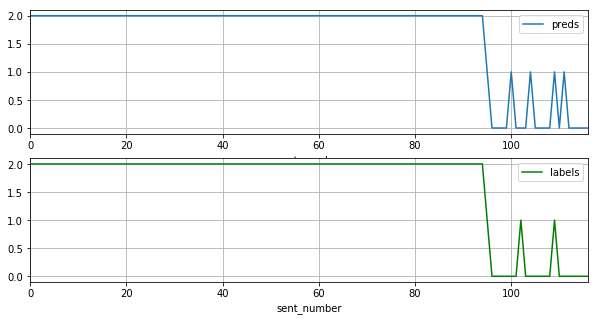

In [7]:
# Choose the document you want to examine
# You can keep running this cell with different indices to visualize different
# documents within this batch of testing
idx = 6

df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Sample predictions on unseen podcast data

In [8]:
test_file = '/home/bmmidei/SliceCast/data/podcasts/hdf5/batch0_0.hdf5'
k = 33
num_samples = 2
preds, labels, pk = net.predict(test_file=test_file,
                    num_samples=num_samples,
                    weights_path=weights_podcast,
                    k=k)

print('Average PK score with k={} on {} examples is: {:0.3f}'.format(k, num_samples, pk))

Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f64b034c550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Average PK score with k=33 on 2 examples is: 0.326


In [9]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)

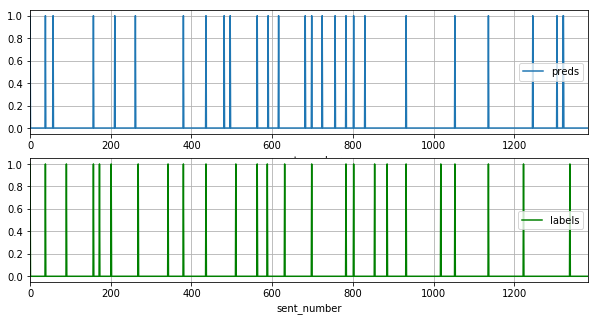

In [11]:
# Choose the document you want to examine
idx = 1

df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Predictions on a single text file

In [28]:
text_file = '/home/bmmidei/SliceCast/data/podcasts/with_timestamps/joe1254.txt'
is_labeled = True
weights_path = weights_podcast # transfer learning

sents, labels = getSingleExample(fname=text_file, is_labeled=is_labeled)
sents = np.expand_dims(sents, axis=0)

preds = net.singlePredict(sents, weights_path=weights_path)

Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f64417d96a0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


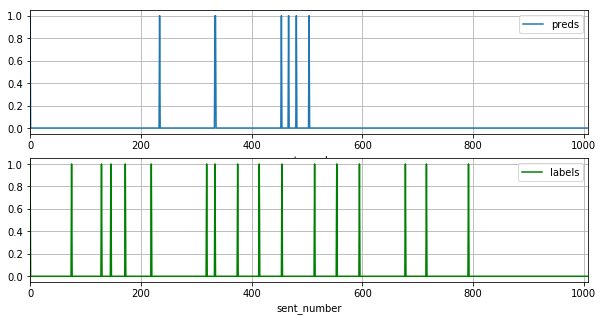

In [29]:
# Place data into a pandas dataframe for analysis
df = pd.DataFrame()

preds = np.argmax(np.squeeze(preds), axis=-1)
df['raw_sentences'] = sents[0]
if is_labeled:
    df['labels'] = labels
df['preds'] = preds
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Keyword Extraction
The following cells are experimental code to extract keywords for each segment in order to provide context for each segment.

In [31]:
from src.postprocess import getSummaries, getTimeStamps
keywords = getSummaries(sents[0], preds)
stamps = getTimeStamps(sents[0], '/home/bmmidei/SliceCast/data/podcasts/with_timestamps/joe1254.json', preds)

In [32]:
seconds = [x%60 for x in stamps]
minutes = [math.floor(x/60) for x in stamps]
for i, (x, y)in enumerate(zip(minutes, seconds)):
    print("{}:{}".format(x, y), end="")
    print([x[0] for x in keywords[i]])

0:0['people', 'things', 'something']
2:58['people', 'medication today', 'opioids']
37:51['ton', 'loot', 'sure']
38:1['people', 'lot', 'story']
41:48['somebody', 'people', 'guys']
51:20['people', 'money', 'words']
53:8['guilty', 'people', 'somebody']
56:3['guy', 'something', 'people']
